In [129]:
#Import Libraries
%matplotlib inline
import datetime as dt
import pyodbc 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import requests
import pandas as pd
import csv
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import preprocessing
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from datetime import datetime
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report

In [50]:
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=DIPDAVS-PC;'
                      'Database=AdventureWorksDW2022;'
                      'Trusted_connection=yes;')

#import The fact internet sales table

In [3]:
sql_for_df = "SELECT [CustomerKey],[SalesTerritoryKey],[OrderQuantity],[SalesOrderNumber],[SalesAmount],[OrderDate] FROM [dbo].[FactInternetSales] "
df = pd.read_sql(sql_for_df , conn)

conn.close()

C:\Users\Hp Envy 17-AE165NR\AppData\Local\Temp\ipykernel_12452\2779508643.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_for_df , conn)


In [4]:
df.head()

,CustomerKey,SalesTerritoryKey,OrderQuantity,SalesOrderNumber,SalesAmount,OrderDate
0,21768,6,1,SO43697,3578.2700,2010-12-29
1,28389,7,1,SO43698,3399.9900,2010-12-29
2,25863,1,1,SO43699,3399.9900,2010-12-29
3,14501,4,1,SO43700,699.0982,2010-12-29
4,11003,9,1,SO43701,3399.9900,2010-12-29


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60398 entries, 0 to 60397
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   CustomerKey        60398 non-null  int64         
 1   SalesTerritoryKey  60398 non-null  int64         
 2   OrderQuantity      60398 non-null  int64         
 3   SalesOrderNumber   60398 non-null  object        
 4   SalesAmount        60398 non-null  float64       
 5   OrderDate          60398 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 2.8+ MB


In [6]:
max(df.OrderDate)

Timestamp('2014-01-28 00:00:00')

In [7]:
df.count().head()

CustomerKey          60398
SalesTerritoryKey    60398
OrderQuantity        60398
SalesOrderNumber     60398
SalesAmount          60398
dtype: int64

In [8]:
df.sort_values(['CustomerKey', 'SalesOrderNumber']).head()

,CustomerKey,SalesTerritoryKey,OrderQuantity,SalesOrderNumber,SalesAmount,OrderDate
96,11000,9,1,SO43793,3399.99,2011-01-19
6396,11000,9,1,SO51522,2319.99,2013-01-18
6397,11000,9,1,SO51522,21.98,2013-01-18
19223,11000,9,1,SO57418,2384.07,2013-05-03
19224,11000,9,1,SO57418,28.99,2013-05-03


In [9]:
print(any(df.duplicated()))

True


In [10]:
df.isnull().sum()

CustomerKey          0
SalesTerritoryKey    0
OrderQuantity        0
SalesOrderNumber     0
SalesAmount          0
OrderDate            0
dtype: int64

Summerizing and Aggregating the Sales Data

In [11]:
new_df = df.groupby(['CustomerKey','SalesOrderNumber','OrderDate','SalesTerritoryKey']).agg({'SalesAmount':'sum','OrderQuantity':'sum'})

In [12]:
new_df.head()

SalesAmount  \
CustomerKey SalesOrderNumber OrderDate  SalesTerritoryKey                
11000       SO43793          2011-01-19 9                      3399.99   
            SO51522          2013-01-18 9                      2341.97   
            SO57418          2013-05-03 9                      2507.03   
11001       SO43767          2011-01-15 9                      3374.99   
            SO51493          2013-01-16 9                      2419.93   

                                                           OrderQuantity  
CustomerKey SalesOrderNumber OrderDate  SalesTerritoryKey                 
11000       SO43793          2011-01-19 9                              1  
            SO51522          2013-01-18 9                              2  
            SO57418          2013-05-03 9                              5  
11001       SO43767          2011-01-15 9                              1  
            SO51493          2013-01-16 9                              6

In [13]:
new_df = new_df.reset_index()

creating a new feature for the data - timeBWtrans

In [14]:
new_df['timeBWtrans'] = new_df.sort_values(['CustomerKey','OrderDate']).groupby(['CustomerKey'])['OrderDate'].diff()

In [15]:
new_df['timeBWtrans'].dtype

dtype('<m8[ns]')

In [16]:
new_df['timeBWtrans'] = new_df['timeBWtrans'].dt.days

In [17]:
new_df.head()

,CustomerKey,SalesOrderNumber,OrderDate,SalesTerritoryKey,SalesAmount,OrderQuantity,timeBWtrans
0,11000,SO43793,2011-01-19,9,3399.99,1,NaN
1,11000,SO51522,2013-01-18,9,2341.97,2,730.0
2,11000,SO57418,2013-05-03,9,2507.03,5,105.0
3,11001,SO43767,2011-01-15,9,3374.99,1,NaN
4,11001,SO51493,2013-01-16,9,2419.93,6,732.0


In [18]:
#Replace the NaN with 0
new_df['timeBWtrans'] = new_df['timeBWtrans'].fillna(0).astype(int) 

In [19]:
new_df.head()

,CustomerKey,SalesOrderNumber,OrderDate,SalesTerritoryKey,SalesAmount,OrderQuantity,timeBWtrans
0,11000,SO43793,2011-01-19,9,3399.99,1,0
1,11000,SO51522,2013-01-18,9,2341.97,2,730
2,11000,SO57418,2013-05-03,9,2507.03,5,105
3,11001,SO43767,2011-01-15,9,3374.99,1,0
4,11001,SO51493,2013-01-16,9,2419.93,6,732


In [20]:
#summarise the df data
new_df = new_df.groupby(['CustomerKey','SalesTerritoryKey']).agg({'SalesAmount':['sum','mean','min','max'],'SalesOrderNumber':'count','OrderDate':['min','max'],'timeBWtrans':['mean'],'OrderQuantity':['sum','mean','min','max']}).reset_index()

In [21]:
new_df.head()

CustomerKey SalesTerritoryKey SalesAmount                                 \
                                        sum         mean      min      max   
0       11000                 9     8248.99  2749.663333  2341.97  3399.99   
1       11001                 9     6383.88  2127.960000   588.96  3374.99   
2       11002                 9     8114.04  2704.680000  2294.99  3399.99   
3       11003                 9     8139.29  2713.096667  2318.96  3399.99   
4       11004                 9     8196.01  2732.003333  2376.96  3399.99   

  SalesOrderNumber  OrderDate            timeBWtrans OrderQuantity            \
             count        min        max        mean           sum      mean   
0                3 2011-01-19 2013-05-03  278.333333             8  2.666667   
1                3 2011-01-15 2013-12-10  353.333333            11  3.666667   
2                3 2011-01-07 2013-02-23  259.333333             4  1.333333   
3                3 2010-12-29 2013-05-10  287.666667             9  3.000000   
4                3 2011-01-23 2013-05-01  276.333333             6  2.000000   

           
  min max  
0   1   5  
1   1   6  
2   1   2  
3   1   4  
4   1   3

In [22]:
#Join the field names to the newly aggregate fields names
new_df.columns = ["_".join(x) for x in new_df.columns.ravel()]

In [23]:
new_df.count().head()

CustomerKey_          18484
SalesTerritoryKey_    18484
SalesAmount_sum       18484
SalesAmount_mean      18484
SalesAmount_min       18484
dtype: int64

In [24]:
new_df = new_df.rename(columns={'CustomerKey_': 'CustomerKey'})

In [25]:
print(any(new_df['CustomerKey'].duplicated()))

False


Import Dim Customer table

In [27]:
sql_for_df = "SELECT [CustomerKey],[BirthDate],[MaritalStatus],[Gender],[YearlyIncome],[TotalChildren],[NumberChildrenAtHome],[EnglishEducation],[EnglishOccupation],[HouseOwnerFlag],[NumberCarsOwned],[DateFirstPurchase],[CommuteDistance]FROM [dbo].[DimCustomer]"
cstm_df = pd.read_sql(sql_for_df , conn)

conn.close()

C:\Users\Hp Envy 17-AE165NR\AppData\Local\Temp\ipykernel_12452\2811122568.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cstm_df = pd.read_sql(sql_for_df , conn)


In [28]:
cstm_df.head()

,CustomerKey,BirthDate,MaritalStatus,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,EnglishEducation,EnglishOccupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance
0,11000,1971-10-06,M,M,90000.0,2,0,Bachelors,Professional,1,0,2011-01-19,1-2 Miles
1,11001,1976-05-10,S,M,60000.0,3,3,Bachelors,Professional,0,1,2011-01-15,0-1 Miles
2,11002,1971-02-09,M,M,60000.0,3,3,Bachelors,Professional,1,1,2011-01-07,2-5 Miles
3,11003,1973-08-14,S,F,70000.0,0,0,Bachelors,Professional,0,1,2010-12-29,5-10 Miles
4,11004,1979-08-05,S,F,80000.0,5,5,Bachelors,Professional,1,4,2011-01-23,1-2 Miles


In [29]:
print(any(cstm_df['CustomerKey'].duplicated()))

False


Import Fact Internet sales reason table

In [31]:
sql_for_df = "SELECT * FROM [dbo].[FactInternetSalesReason]"
fisr_df = pd.read_sql(sql_for_df , conn)

conn.close()

C:\Users\Hp Envy 17-AE165NR\AppData\Local\Temp\ipykernel_12452\832300480.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  fisr_df = pd.read_sql(sql_for_df , conn)


In [32]:
fisr_df.head()

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey
0,SO43697,1,5
1,SO43697,1,9
2,SO43702,1,5
3,SO43702,1,9
4,SO43703,1,5


Import Dim Sales Reason Table

In [34]:
sql_for_df = "SELECT * FROM [dbo].[DimSalesReason]"
sr_df = pd.read_sql(sql_for_df , conn)

conn.close()

C:\Users\Hp Envy 17-AE165NR\AppData\Local\Temp\ipykernel_12452\4255960514.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sr_df = pd.read_sql(sql_for_df , conn)


In [35]:
sr_df.head()

,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType
0,1,1,Price,Other
1,2,2,On Promotion,Promotion
2,3,3,Magazine Advertisement,Marketing
3,4,4,Television Advertisement,Marketing
4,5,5,Manufacturer,Other


In [36]:
sr_df.count().head()

SalesReasonKey             10
SalesReasonAlternateKey    10
SalesReasonName            10
SalesReasonReasonType      10
dtype: int64

In [37]:
# join both the new_df table with the cstm_df
result = pd.merge(new_df, cstm_df,
                 on = 'CustomerKey')

In [38]:
result.head()

,CustomerKey,SalesTerritoryKey_,SalesAmount_sum,SalesAmount_mean,SalesAmount_min,SalesAmount_max,SalesOrderNumber_count,OrderDate_min,OrderDate_max,timeBWtrans_mean,...,Gender,YearlyIncome,TotalChildren,NumberChildrenAtHome,EnglishEducation,EnglishOccupation,HouseOwnerFlag,NumberCarsOwned,DateFirstPurchase,CommuteDistance
0,11000,9,8248.99,2749.663333,2341.97,3399.99,3,2011-01-19,2013-05-03,278.333333,...,M,90000.0,2,0,Bachelors,Professional,1,0,2011-01-19,1-2 Miles
1,11001,9,6383.88,2127.960000,588.96,3374.99,3,2011-01-15,2013-12-10,353.333333,...,M,60000.0,3,3,Bachelors,Professional,0,1,2011-01-15,0-1 Miles
2,11002,9,8114.04,2704.680000,2294.99,3399.99,3,2011-01-07,2013-02-23,259.333333,...,M,60000.0,3,3,Bachelors,Professional,1,1,2011-01-07,2-5 Miles
3,11003,9,8139.29,2713.096667,2318.96,3399.99,3,2010-12-29,2013-05-10,287.666667,...,F,70000.0,0,0,Bachelors,Professional,0,1,2010-12-29,5-10 Miles
4,11004,9,8196.01,2732.003333,2376.96,3399.99,3,2011-01-23,2013-05-01,276.333333,...,F,80000.0,5,5,Bachelors,Professional,1,4,2011-01-23,1-2 Miles


In [39]:
result.count().head()

CustomerKey           18484
SalesTerritoryKey_    18484
SalesAmount_sum       18484
SalesAmount_mean      18484
SalesAmount_min       18484
dtype: int64

In [40]:
reason = pd.merge(fisr_df, sr_df,
                 on = 'SalesReasonKey')

In [41]:
reason.head()

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType
0,SO43697,1,5,5,Manufacturer,Other
1,SO43702,1,5,5,Manufacturer,Other
2,SO43703,1,5,5,Manufacturer,Other
3,SO43706,1,5,5,Manufacturer,Other
4,SO43707,1,5,5,Manufacturer,Other


checking both tables for duplicates in the data

In [42]:
print(any(reason['SalesOrderNumber'].duplicated()))

True


In [43]:
reason.head(10)

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType
0,SO43697,1,5,5,Manufacturer,Other
1,SO43702,1,5,5,Manufacturer,Other
2,SO43703,1,5,5,Manufacturer,Other
3,SO43706,1,5,5,Manufacturer,Other
4,SO43707,1,5,5,Manufacturer,Other
5,SO43709,1,5,5,Manufacturer,Other
6,SO43710,1,5,5,Manufacturer,Other
7,SO43711,1,5,5,Manufacturer,Other
8,SO43712,1,5,5,Manufacturer,Other
9,SO43713,1,5,5,Manufacturer,Other


In [44]:
reason[reason['SalesOrderNumber'] == 'SO43702']
#Under the sales reason name there seems to be two reasons why the customer bought that product

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType
1,SO43702,1,5,5,Manufacturer,Other
1819,SO43702,1,9,9,Quality,Other


In [45]:
# dummify the sales reason name column to make its cntents variables
reasonn = pd.get_dummies(reason['SalesReasonName'], columns=['Price', 'On Promotion', 'Magazine Advertisement', 'TV', 'Manufacturer', 'Review', 'Demo Event', 'Sponsorship', 'Quality', 'Other'], dtype=int)


In [46]:
reasonn.head()

,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [47]:
reason = pd.concat([reason, reasonn], axis=1)

In [48]:
print(any(reason['SalesOrderNumber'].duplicated()))

True


In [49]:
reason.head()

,SalesOrderNumber,SalesOrderLineNumber,SalesReasonKey,SalesReasonAlternateKey,SalesReasonName,SalesReasonReasonType,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,SO43697,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
1,SO43702,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
2,SO43703,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
3,SO43706,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0
4,SO43707,1,5,5,Manufacturer,Other,1,0,0,0,0,0,0


In [51]:
sql_for_df = "SELECT [CustomerKey],[SalesOrderNumber] FROM [dbo].[FactInternetSales]"
fis_df = pd.read_sql(sql_for_df , conn)

conn.close()

C:\Users\Hp Envy 17-AE165NR\AppData\Local\Temp\ipykernel_12452\4003399429.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  fis_df = pd.read_sql(sql_for_df , conn)


In [52]:
#Join factinternetsales back to prepared Salesreason data
reason = pd.merge(fis_df,
                 reason,
                 on='SalesOrderNumber')

In [53]:
reason.count().head()

CustomerKey                188157
SalesOrderNumber           188157
SalesOrderLineNumber       188157
SalesReasonKey             188157
SalesReasonAlternateKey    188157
dtype: int64

In [54]:
#Aggregate Sales Reason to prevent duplication of customer information
reason = reason.groupby('CustomerKey').agg({'Manufacturer':'max', 
                         'On Promotion':'max', 
                         'Other':'max',
                          'Price':'max',
                            'Quality':'max',
                              'Review':'max',
                                'Television  Advertisement':'max'})

In [55]:
#Reset the index to create a proper structure for the dataframe
reason = reason.reset_index()

In [56]:
reason.head()

,CustomerKey,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement
0,11000,0,1,0,1,0,0,0
1,11001,0,0,0,1,0,0,0
2,11002,0,1,0,0,0,0,0
3,11003,0,0,0,1,0,0,0
4,11004,0,0,0,1,0,0,0


In [57]:
#checking for duplicates
print(any(reason['CustomerKey'].duplicated()))

False


In [58]:
reason.count().head()

CustomerKey     17022
Manufacturer    17022
On Promotion    17022
Other           17022
Price           17022
dtype: int64

In [59]:
# MERGE ALL THE DIFFERENT DATASETS INTO ONE 
final_data = pd.merge(result,
                     reason,
                     on = 'CustomerKey', how = 'left')

In [60]:
final_data.count().head(5)

CustomerKey           18484
SalesTerritoryKey_    18484
SalesAmount_sum       18484
SalesAmount_mean      18484
SalesAmount_min       18484
dtype: int64

In [61]:
# Deriving extra fields 
final_data['OrderDate_max'] = pd.to_datetime(final_data['OrderDate_max'])
final_data['DateFirstPurchase'] = pd.to_datetime(final_data['DateFirstPurchase'])
final_data['BirthDate'] = pd.to_datetime(final_data['BirthDate'])

# Calculate CustomerTenure and Customer_Age
final_data['CustomerTenure'] = ((final_data['OrderDate_max'] - final_data['DateFirstPurchase']) / np.timedelta64(1, 'M')).astype(int)
final_data['Customer_Age'] = ((final_data['OrderDate_max'] - final_data['BirthDate']) / np.timedelta64(1, 'Y')).astype(int)

# Convert 'Cuttoff_date' to datetime format
final_data['Cuttoff_date'] = pd.to_datetime('2013-05-31')

# Convert 'Last_purchase_date' to date format
final_data['Last_purchase_date'] = final_data['OrderDate_max'].dt.date

In [62]:
#Convert dates from objects to date formats
final_data['Last_purchase_date'] = pd.to_datetime(final_data['Last_purchase_date'],format="%Y-%m-%d")

In [63]:
final_data['Cuttoff_date'] = pd.to_datetime(final_data['Cuttoff_date'],format="%Y-%m-%d")

In [64]:
#Create the Target variable
final_data['Churn'] = np.where(final_data['Last_purchase_date'] <= final_data['Cuttoff_date'] , 1, 0)

In [65]:
final_data.head()

,CustomerKey,SalesTerritoryKey_,SalesAmount_sum,SalesAmount_mean,SalesAmount_min,SalesAmount_max,SalesOrderNumber_count,OrderDate_min,OrderDate_max,timeBWtrans_mean,...,Other,Price,Quality,Review,Television Advertisement,CustomerTenure,Customer_Age,Cuttoff_date,Last_purchase_date,Churn
0,11000,9,8248.99,2749.663333,2341.97,3399.99,3,2011-01-19,2013-05-03,278.333333,...,0.0,1.0,0.0,0.0,0.0,26,41,2013-05-31,2013-05-03,1
1,11001,9,6383.88,2127.960000,588.96,3374.99,3,2011-01-15,2013-12-10,353.333333,...,0.0,1.0,0.0,0.0,0.0,34,37,2013-05-31,2013-12-10,0
2,11002,9,8114.04,2704.680000,2294.99,3399.99,3,2011-01-07,2013-02-23,259.333333,...,0.0,0.0,0.0,0.0,0.0,25,42,2013-05-31,2013-02-23,1
3,11003,9,8139.29,2713.096667,2318.96,3399.99,3,2010-12-29,2013-05-10,287.666667,...,0.0,1.0,0.0,0.0,0.0,27,39,2013-05-31,2013-05-10,1
4,11004,9,8196.01,2732.003333,2376.96,3399.99,3,2011-01-23,2013-05-01,276.333333,...,0.0,1.0,0.0,0.0,0.0,26,33,2013-05-31,2013-05-01,1


In [66]:
#Rename SalesTerritoryKey_ to SalesTerritoryKey
final_data = final_data.rename(columns={'SalesTerritoryKey_': 'SalesTerritoryKey'})

In [67]:
final_data.head()

,CustomerKey,SalesTerritoryKey,SalesAmount_sum,SalesAmount_mean,SalesAmount_min,SalesAmount_max,SalesOrderNumber_count,OrderDate_min,OrderDate_max,timeBWtrans_mean,...,Other,Price,Quality,Review,Television Advertisement,CustomerTenure,Customer_Age,Cuttoff_date,Last_purchase_date,Churn
0,11000,9,8248.99,2749.663333,2341.97,3399.99,3,2011-01-19,2013-05-03,278.333333,...,0.0,1.0,0.0,0.0,0.0,26,41,2013-05-31,2013-05-03,1
1,11001,9,6383.88,2127.960000,588.96,3374.99,3,2011-01-15,2013-12-10,353.333333,...,0.0,1.0,0.0,0.0,0.0,34,37,2013-05-31,2013-12-10,0
2,11002,9,8114.04,2704.680000,2294.99,3399.99,3,2011-01-07,2013-02-23,259.333333,...,0.0,0.0,0.0,0.0,0.0,25,42,2013-05-31,2013-02-23,1
3,11003,9,8139.29,2713.096667,2318.96,3399.99,3,2010-12-29,2013-05-10,287.666667,...,0.0,1.0,0.0,0.0,0.0,27,39,2013-05-31,2013-05-10,1
4,11004,9,8196.01,2732.003333,2376.96,3399.99,3,2011-01-23,2013-05-01,276.333333,...,0.0,1.0,0.0,0.0,0.0,26,33,2013-05-31,2013-05-01,1


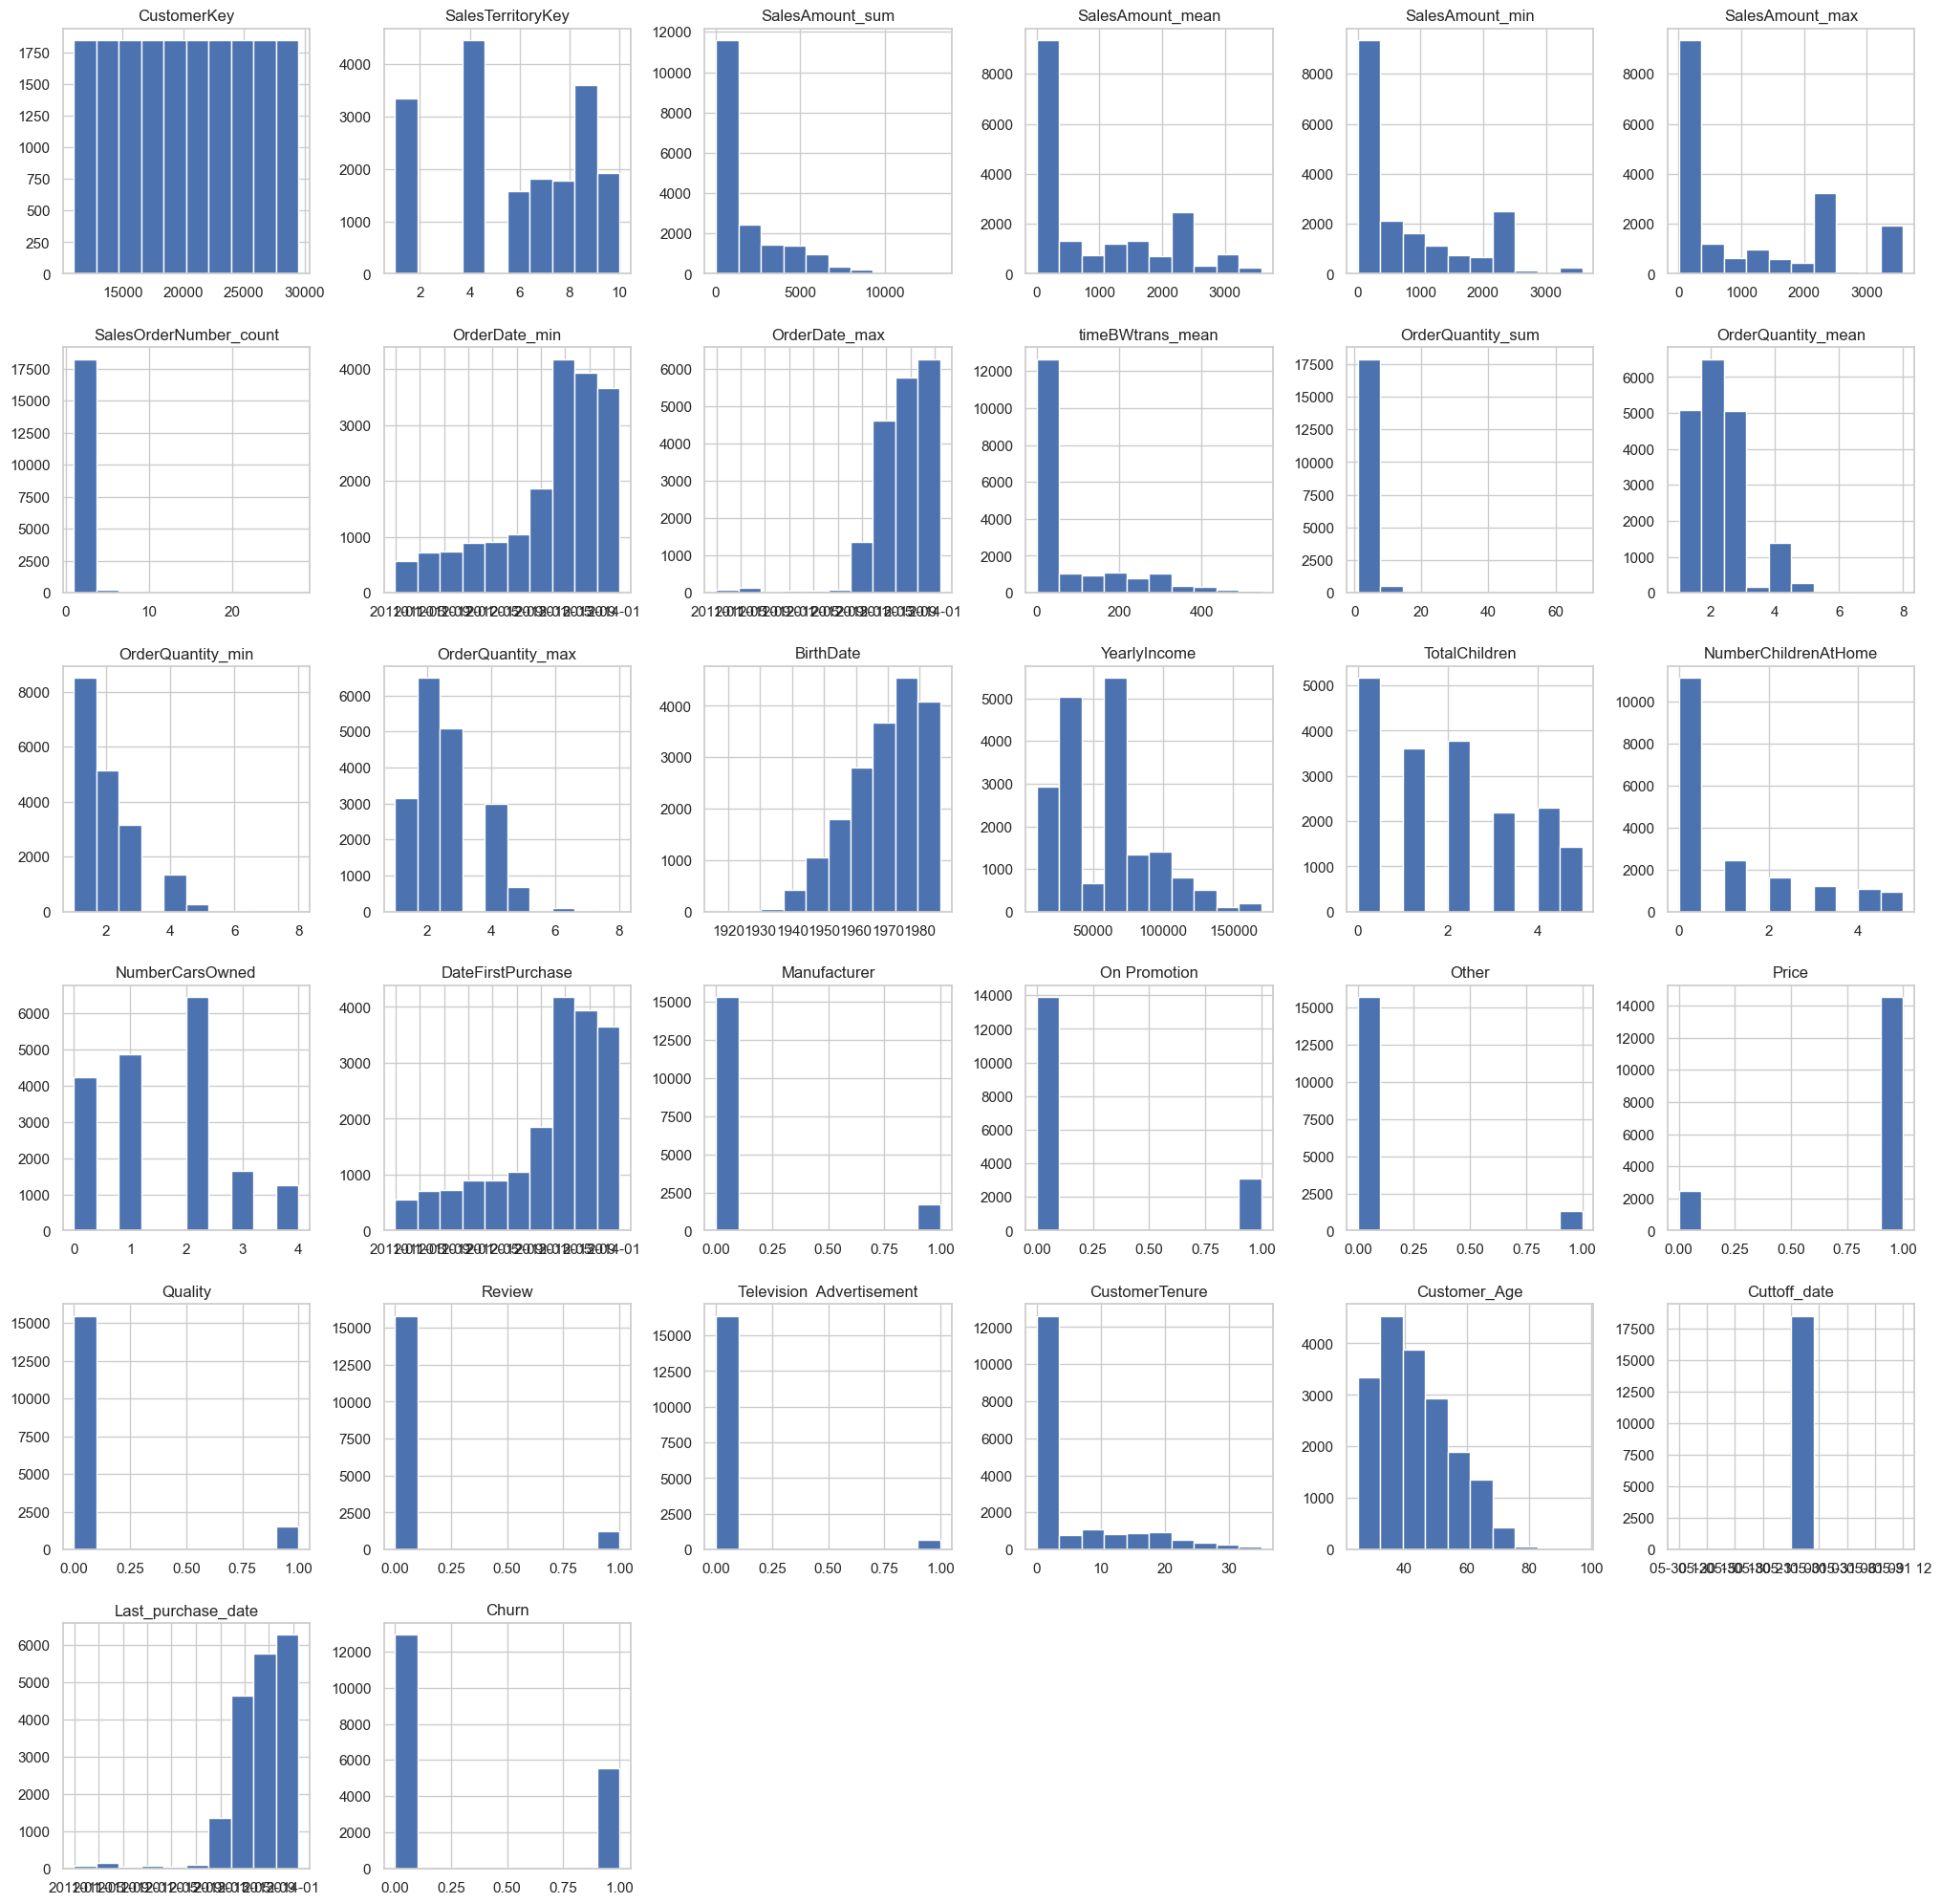

In [68]:
final_data.hist(figsize=(25,25))
plt.show()

In [69]:
final_data.dtypes

CustomerKey                           int64
SalesTerritoryKey                     int64
SalesAmount_sum                     float64
SalesAmount_mean                    float64
SalesAmount_min                     float64
SalesAmount_max                     float64
SalesOrderNumber_count                int64
OrderDate_min                datetime64[ns]
OrderDate_max                datetime64[ns]
timeBWtrans_mean                    float64
OrderQuantity_sum                     int64
OrderQuantity_mean                  float64
OrderQuantity_min                     int64
OrderQuantity_max                     int64
BirthDate                    datetime64[ns]
MaritalStatus                        object
Gender                               object
YearlyIncome                        float64
TotalChildren                         int64
NumberChildrenAtHome                  int64
EnglishEducation                     object
EnglishOccupation                    object
HouseOwnerFlag                  

In [70]:
# Exclude features that have to do with time or dates
numerics = ['uint8','int16', 'int32', 'int64', 'float16', 'float32', 'float64','object']
final_data = final_data.select_dtypes(include=numerics)

In [71]:
final_data.dtypes

CustomerKey                    int64
SalesTerritoryKey              int64
SalesAmount_sum              float64
SalesAmount_mean             float64
SalesAmount_min              float64
SalesAmount_max              float64
SalesOrderNumber_count         int64
timeBWtrans_mean             float64
OrderQuantity_sum              int64
OrderQuantity_mean           float64
OrderQuantity_min              int64
OrderQuantity_max              int64
MaritalStatus                 object
Gender                        object
YearlyIncome                 float64
TotalChildren                  int64
NumberChildrenAtHome           int64
EnglishEducation              object
EnglishOccupation             object
HouseOwnerFlag                object
NumberCarsOwned                int64
CommuteDistance               object
Manufacturer                 float64
On Promotion                 float64
Other                        float64
Price                        float64
Quality                      float64
R

In [72]:
# Exclude features that are keys
final_data.drop(['CustomerKey','SalesTerritoryKey', 'timeBWtrans_mean'], axis=1,inplace=True)

In [73]:
final_data.dtypes

SalesAmount_sum              float64
SalesAmount_mean             float64
SalesAmount_min              float64
SalesAmount_max              float64
SalesOrderNumber_count         int64
OrderQuantity_sum              int64
OrderQuantity_mean           float64
OrderQuantity_min              int64
OrderQuantity_max              int64
MaritalStatus                 object
Gender                        object
YearlyIncome                 float64
TotalChildren                  int64
NumberChildrenAtHome           int64
EnglishEducation              object
EnglishOccupation             object
HouseOwnerFlag                object
NumberCarsOwned                int64
CommuteDistance               object
Manufacturer                 float64
On Promotion                 float64
Other                        float64
Price                        float64
Quality                      float64
Review                       float64
Television  Advertisement    float64
CustomerTenure                 int32
C

In [74]:
final_data['Churn'].value_counts()

Churn
0    12925
1     5559
Name: count, dtype: int64

In [75]:
churners = final_data.loc[final_data['Churn'] == 1]

In [76]:
churners['Churn'].value_counts()

Churn
1    5559
Name: count, dtype: int64

In [77]:
non_churners = final_data.loc[final_data['Churn'] == 0]

In [78]:
non_churners['Churn'].value_counts()

Churn
0    12925
Name: count, dtype: int64

In [79]:
scoring_data,non_churners = train_test_split(non_churners,test_size=0.5,random_state=30)

In [80]:
non_churners['Churn'].value_counts()

Churn
0    6463
Name: count, dtype: int64

In [81]:
# THIS IS MY SCORING DATA
scoring_data['Churn'].value_counts()

Churn
0    6462
Name: count, dtype: int64

In [82]:
modeling_data = pd.concat([churners,non_churners],ignore_index=True)

# Exploratory Data Analysis

In [83]:
modeling_data.head()

,SalesAmount_sum,SalesAmount_mean,SalesAmount_min,SalesAmount_max,SalesOrderNumber_count,OrderQuantity_sum,OrderQuantity_mean,OrderQuantity_min,OrderQuantity_max,MaritalStatus,...,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement,CustomerTenure,Customer_Age,Churn
0,8248.99,2749.663333,2341.97,3399.99,3,8,2.666667,1,5,M,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,26,41,1
1,8114.04,2704.680000,2294.99,3399.99,3,4,1.333333,1,2,M,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,25,42,1
2,8139.29,2713.096667,2318.96,3399.99,3,9,3.000000,1,4,S,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,27,39,1
3,8196.01,2732.003333,2376.96,3399.99,3,6,2.000000,1,3,S,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,26,33,1
4,8121.33,2707.110000,2362.27,3374.99,3,6,2.000000,1,4,S,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,27,36,1


In [84]:
modeling_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12022 entries, 0 to 12021
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SalesAmount_sum            12022 non-null  float64
 1   SalesAmount_mean           12022 non-null  float64
 2   SalesAmount_min            12022 non-null  float64
 3   SalesAmount_max            12022 non-null  float64
 4   SalesOrderNumber_count     12022 non-null  int64  
 5   OrderQuantity_sum          12022 non-null  int64  
 6   OrderQuantity_mean         12022 non-null  float64
 7   OrderQuantity_min          12022 non-null  int64  
 8   OrderQuantity_max          12022 non-null  int64  
 9   MaritalStatus              12022 non-null  object 
 10  Gender                     12022 non-null  object 
 11  YearlyIncome               12022 non-null  float64
 12  TotalChildren              12022 non-null  int64  
 13  NumberChildrenAtHome       12022 non-null  int

<Axes: xlabel='Churn', ylabel='count'>

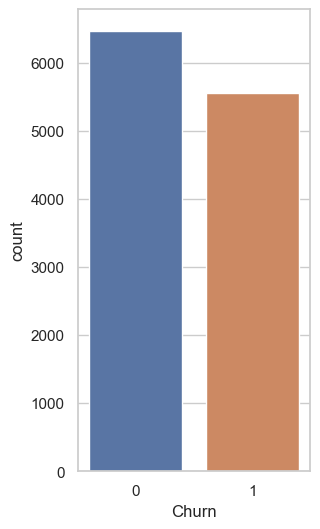

In [85]:
plt.figure(figsize=(3,6))
sns.countplot(x='Churn', data=modeling_data)

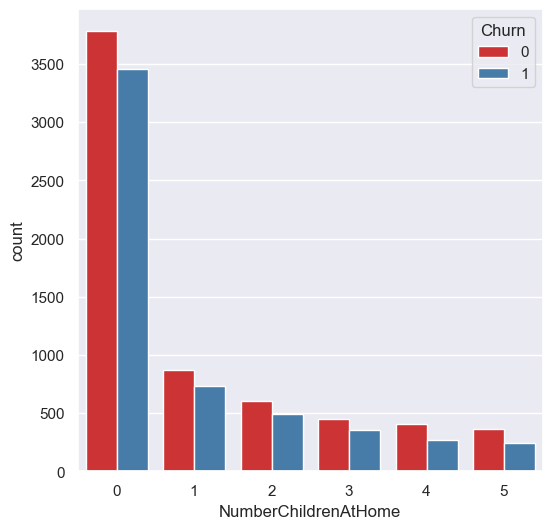

In [86]:
sns.set(style="darkgrid")
plt.figure(figsize=(6,6))
sns.countplot(x='NumberChildrenAtHome',
              hue='Churn',
              data=modeling_data,
             palette='Set1')
plt.show()
# customers who are more likely to churn have fewer children than those who won't churn

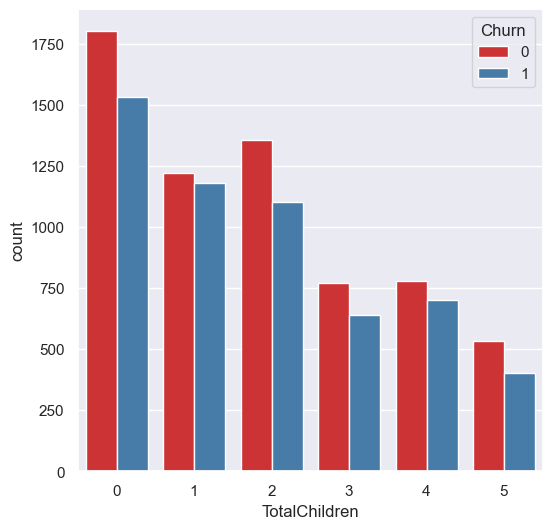

In [87]:
sns.set(style="darkgrid")
plt.figure(figsize=(6,6))
sns.countplot(x='TotalChildren',
              hue='Churn',
              data=modeling_data,
             palette='Set1')
plt.show()
# customers with fewer total number of children in general are more likely to churn

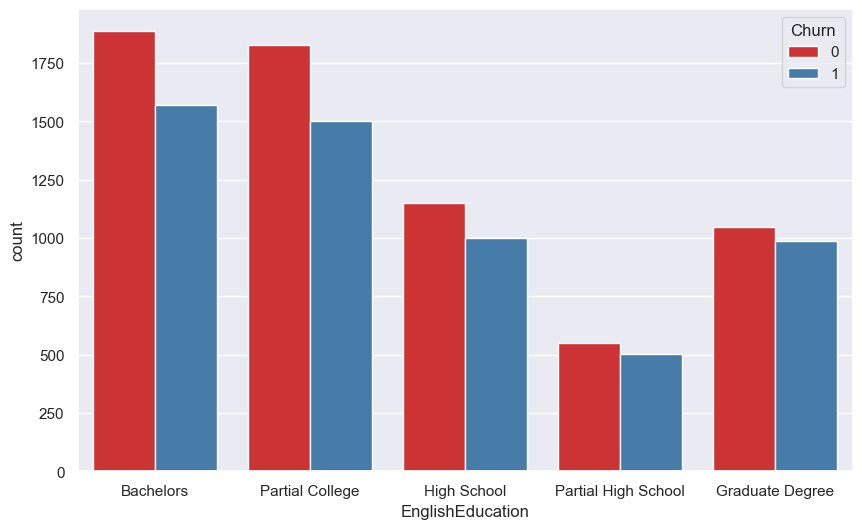

In [88]:
sns.set(style="darkgrid")
plt.figure(figsize=(10,6))
sns.countplot(x='EnglishEducation',
              hue='Churn',
              data=modeling_data,
             palette='Set1')
plt.show()
# the data shows non-churners are more likely to have a degree of some kind than churners

<Axes: ylabel='Frequency'>

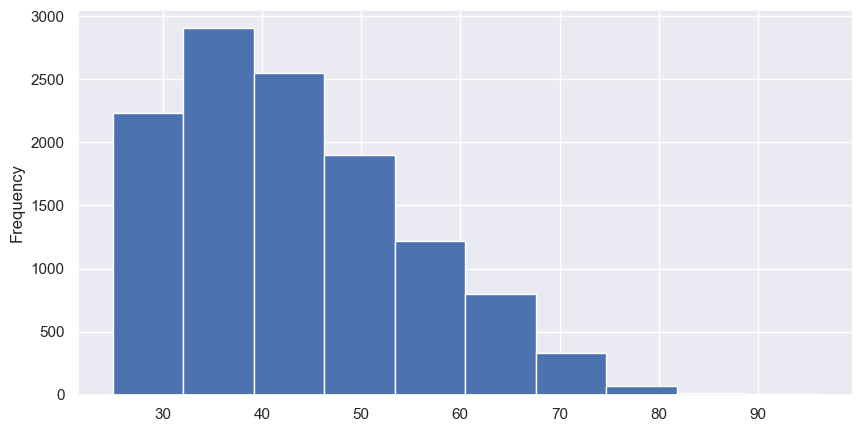

In [89]:
modeling_data['Customer_Age'].plot.hist(bins=10, figsize=(10,5))
# from the vizualisation we can tell that majority of the customers are between the ages of 30 and 50

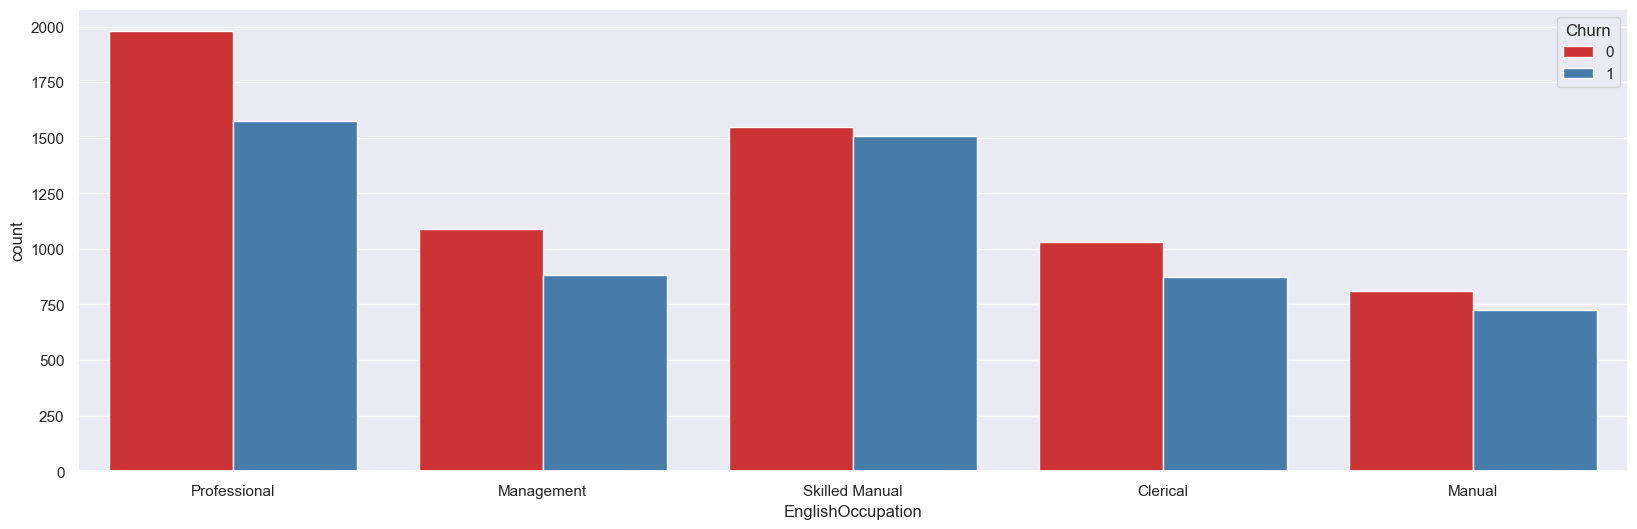

In [90]:
sns.set(style="darkgrid")
plt.figure(figsize=(20,6))
sns.countplot(x='EnglishOccupation',                    
              hue='Churn',
              data=modeling_data,
             palette='Set1')
plt.show()
 # From the visualization, we can tell that a bulk of potential churners happen to have professional 
# and skilled manual occupations

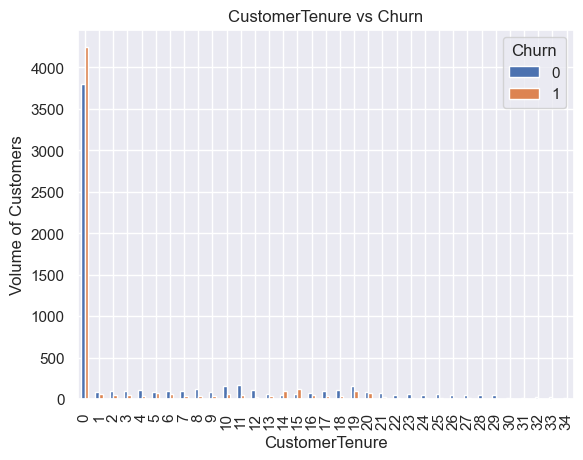

<Figure size 2000x600 with 0 Axes>

In [91]:
pd.crosstab(modeling_data.CustomerTenure,modeling_data.Churn).plot(kind='bar')
plt.title('CustomerTenure vs Churn')
plt.xlabel('CustomerTenure')
plt.ylabel('Volume of Customers')

plt.figure(figsize = (20,6))

plt.savefig('pur_fre_pout_bar')
# Customers are most likley to churn if they have been customers for less than 12 months.

Text(0.5, 0, 'CustomerTenure')

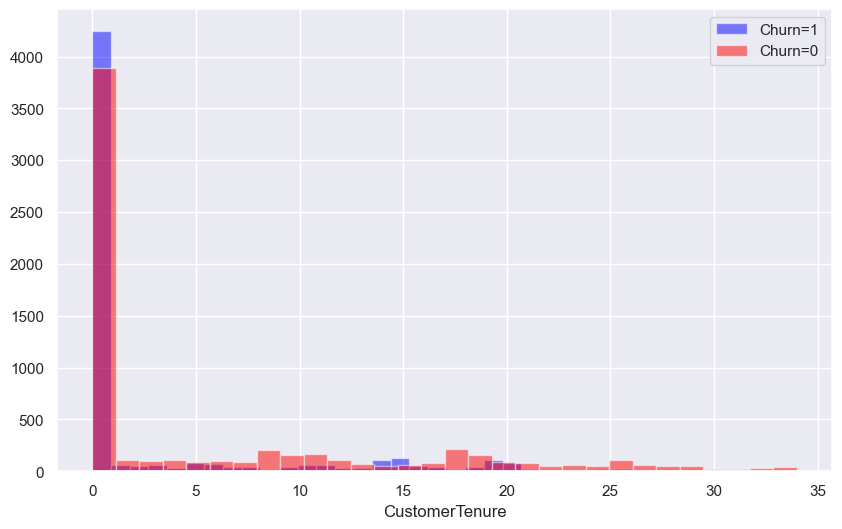

In [92]:
plt.figure(figsize=(10,6))
modeling_data[modeling_data['Churn']==1]['CustomerTenure'].hist(alpha=0.5,color='blue',
                                              bins=30,label='Churn=1')
modeling_data[modeling_data['Churn']==0]['CustomerTenure'].hist(alpha=0.5,color='red',
                                              bins=30,label='Churn=0')
plt.legend()
plt.xlabel('CustomerTenure')

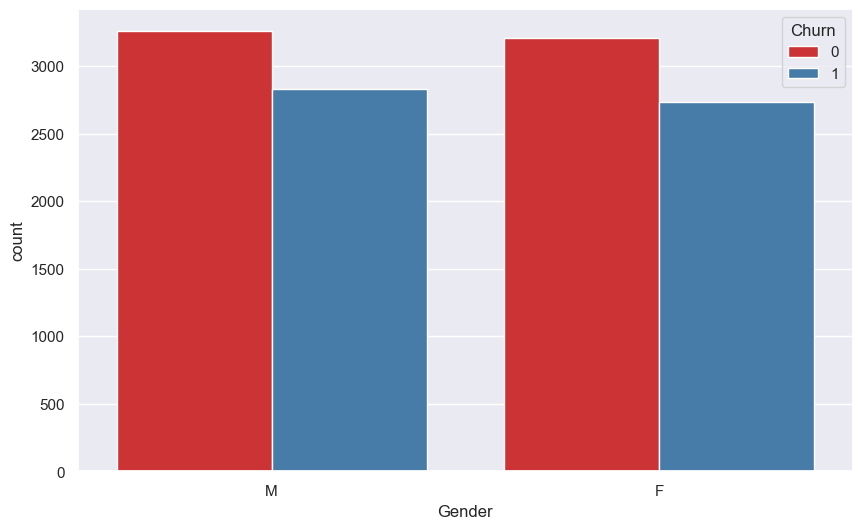

In [93]:
sns.set(style="darkgrid")
plt.figure(figsize=(10,6))
sns.countplot(x='Gender',                    
              hue='Churn',
              data=modeling_data,
             palette='Set1')
plt.show()
#Gender doesnt really affect churning

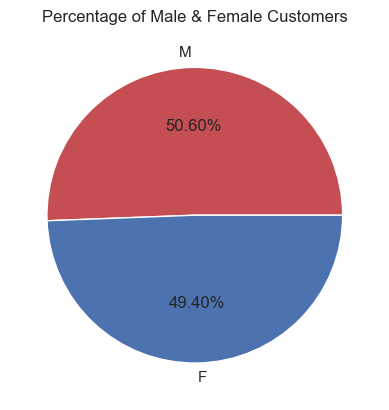

In [94]:
M = modeling_data.loc[modeling_data['Gender'] == 'M'].count()[0]
F = modeling_data.loc[modeling_data['Gender'] == 'F'].count()[0]

labels = ['M', 'F']
colors = ['r', 'b']

plt.pie([M, F], labels=labels, colors=colors, autopct='%.2f%%')

plt.title('Percentage of Male & Female Customers')
plt.show() 

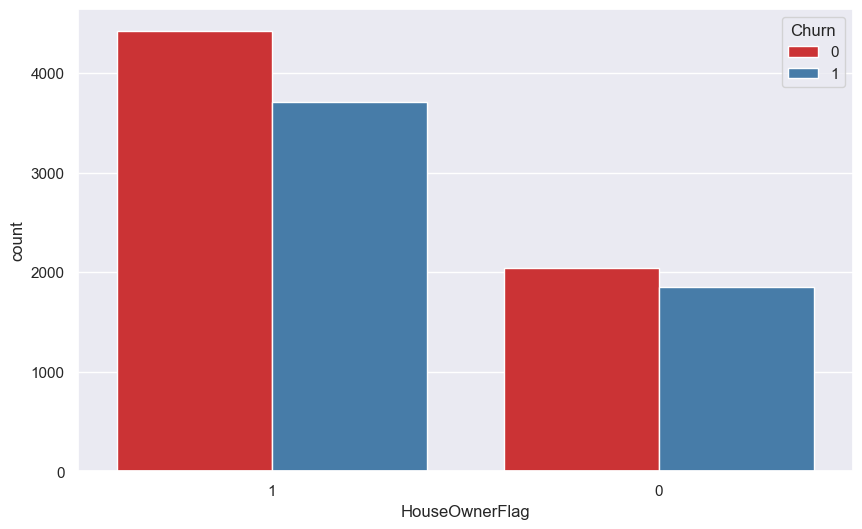

In [95]:
sns.set(style="darkgrid")
plt.figure(figsize=(10,6))
sns.countplot(x='HouseOwnerFlag',                    
              hue='Churn',
              data=modeling_data,
             palette='Set1')
plt.show()
#Most home owners are likely to churn

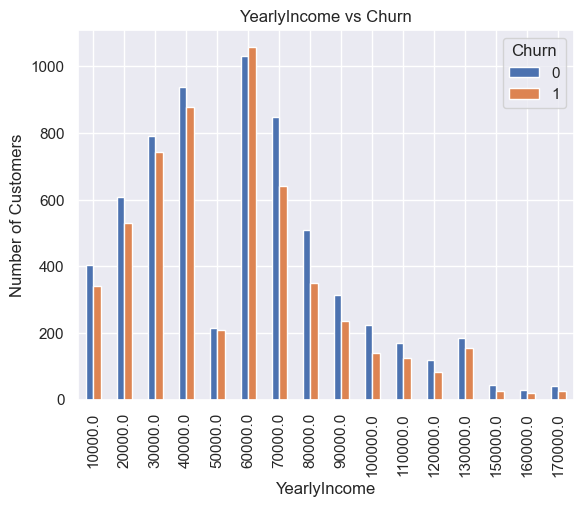

In [96]:
pd.crosstab(modeling_data.YearlyIncome,modeling_data.Churn).plot(kind='bar')
plt.title('YearlyIncome vs Churn')
plt.xlabel('YearlyIncome')
plt.ylabel('Number of Customers')


plt.savefig('pur_fre_pout_bar')
# larger number of non-churners than churners hence it appears as if non-churners earn more than churners in general

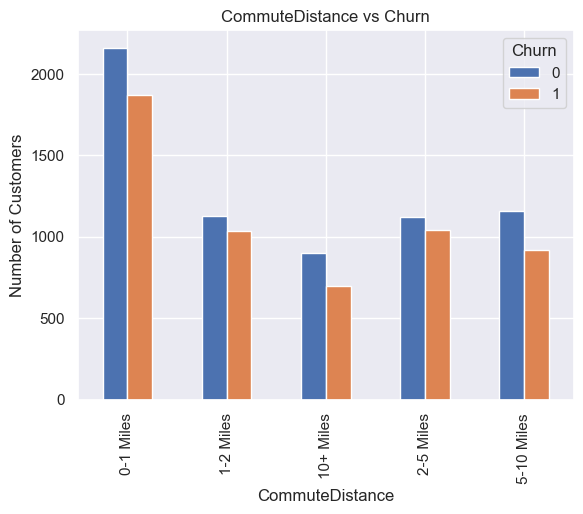

In [97]:
pd.crosstab(modeling_data.CommuteDistance,modeling_data.Churn).plot(kind='bar')
plt.title('CommuteDistance vs Churn')
plt.xlabel('CommuteDistance')
plt.ylabel('Number of Customers')


plt.savefig('pur_fre_pout_bar')
# Customers who travel less than 1 Mile to work are more likely to churn

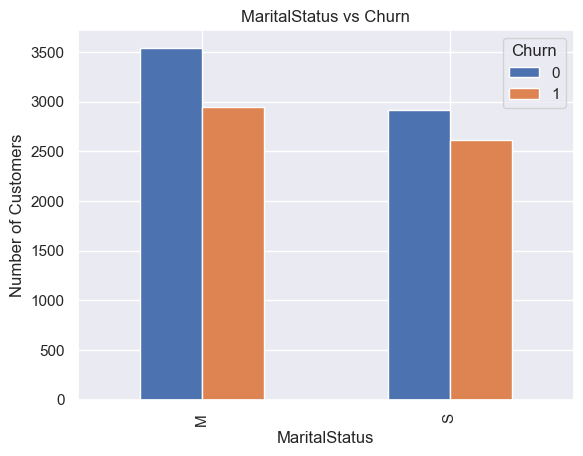

In [98]:
pd.crosstab(modeling_data.MaritalStatus,modeling_data.Churn).plot(kind='bar')
plt.title('MaritalStatus vs Churn')
plt.xlabel('MaritalStatus')
plt.ylabel('Number of Customers')


plt.savefig('pur_fre_pout_bar')
#Married people are more likely to churm

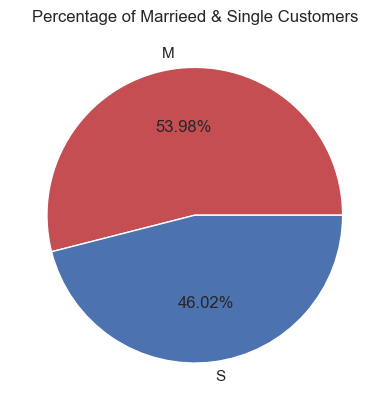

In [99]:
M = modeling_data.loc[modeling_data['MaritalStatus'] == 'M'].count()[0]
S = modeling_data.loc[modeling_data['MaritalStatus'] == 'S'].count()[0]

labels = ['M', 'S']
colors = ['r', 'b']

plt.pie([M, S], labels=labels, colors=colors, autopct='%.2f%%')

plt.title('Percentage of Marrieed & Single Customers')
plt.show() 

In [100]:
numerical_columns = modeling_data.select_dtypes(include=['int', 'float'])

In [101]:
#measures of central tendencies - investigating the difference between the averages of independent variables vs the target variables
numerical_columns.groupby('Churn').mean()

,SalesAmount_sum,SalesAmount_mean,SalesAmount_min,SalesAmount_max,SalesOrderNumber_count,OrderQuantity_sum,OrderQuantity_mean,OrderQuantity_min,OrderQuantity_max,YearlyIncome,...,NumberCarsOwned,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement,CustomerTenure,Customer_Age
Churn,,,,,,,,,,,,,,,,,,,,,
0,1631.944412,874.415895,715.014440,1035.401284,1.595853,3.512610,2.266315,1.896333,2.646604,58101.500851,...,1.527309,0.077704,0.190849,0.080366,0.872379,0.068220,0.075874,0.04426,5.790190,44.047501
1,1503.142648,1013.761415,883.673023,1143.002904,1.268214,2.689333,2.161540,1.944414,2.378305,55538.765965,...,1.466631,0.151131,0.170567,0.066045,0.800079,0.143792,0.063269,0.02380,2.918511,43.232416


In [102]:
modeling_data.isnull().sum()

SalesAmount_sum                0
SalesAmount_mean               0
SalesAmount_min                0
SalesAmount_max                0
SalesOrderNumber_count         0
OrderQuantity_sum              0
OrderQuantity_mean             0
OrderQuantity_min              0
OrderQuantity_max              0
MaritalStatus                  0
Gender                         0
YearlyIncome                   0
TotalChildren                  0
NumberChildrenAtHome           0
EnglishEducation               0
EnglishOccupation              0
HouseOwnerFlag                 0
NumberCarsOwned                0
CommuteDistance                0
Manufacturer                 970
On Promotion                 970
Other                        970
Price                        970
Quality                      970
Review                       970
Television  Advertisement    970
CustomerTenure                 0
Customer_Age                   0
Churn                          0
dtype: int64

<Axes: >

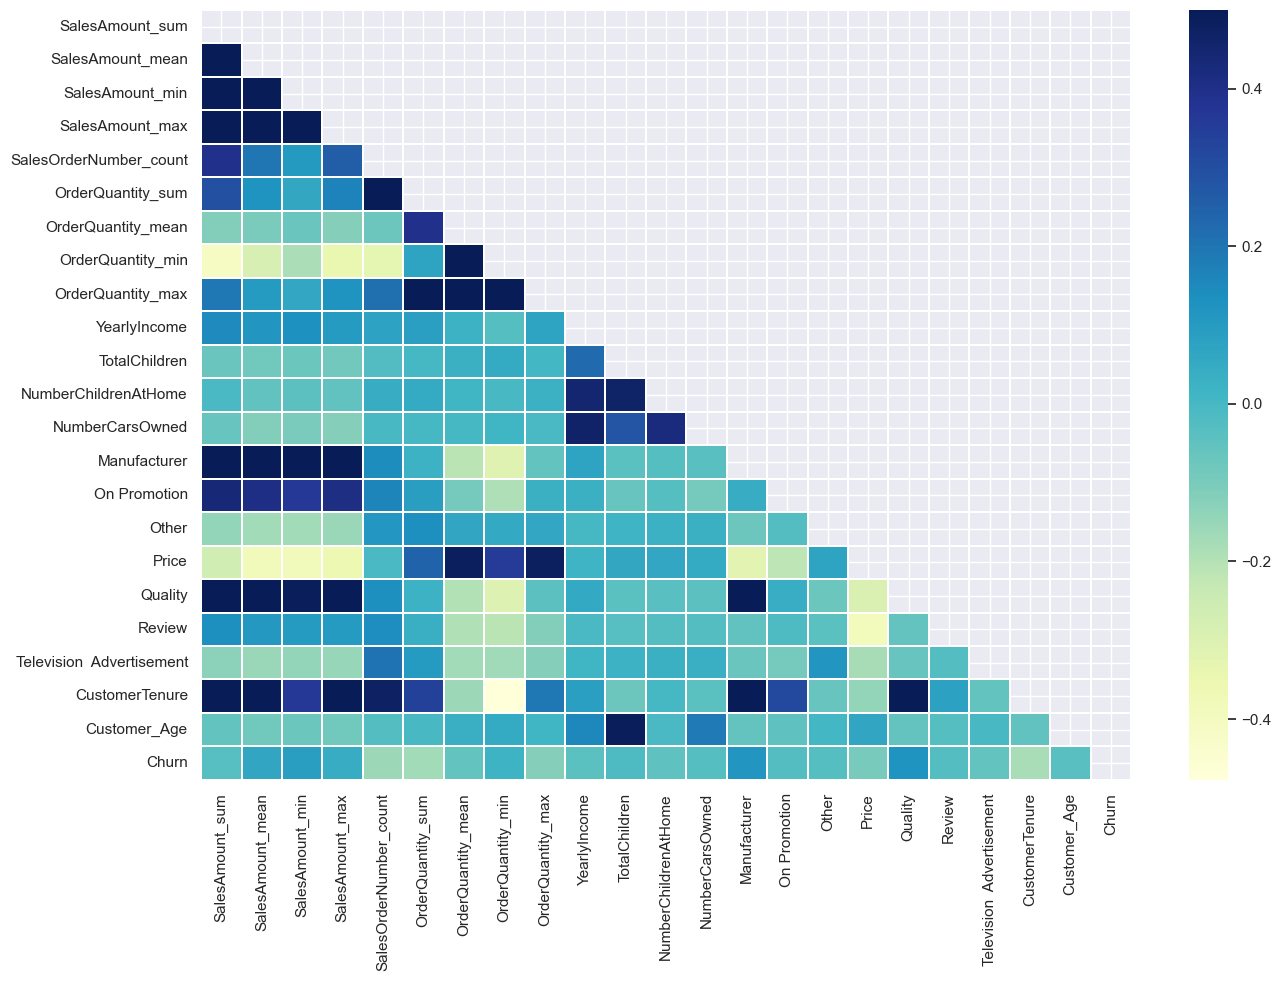

In [103]:
# Calculate correlations
corr = numerical_columns.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
# Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr,
            vmax=.5,
            mask=mask,
            # annot=True, fmt='.2f',
            linewidths=.2, cmap="YlGnBu")

In [257]:
corr_matrix = numerical_columns.corr()

In [258]:
corr_unstacked = corr_matrix.abs().unstack()

In [259]:
corr_unstacked = corr_unstacked[corr_unstacked != 1]

In [260]:
sorted_corr = corr_unstacked.sort_values(ascending=False)

In [271]:
top_10_corr = sorted_corr.head(50)

In [272]:
print(top_10_corr)

SalesAmount_max         SalesAmount_mean          0.974977
SalesAmount_mean        SalesAmount_max           0.974977
Quality                 Manufacturer              0.956432
Manufacturer            Quality                   0.956432
SalesAmount_min         SalesAmount_mean          0.956363
SalesAmount_mean        SalesAmount_min           0.956363
SalesAmount_sum         SalesAmount_max           0.920299
SalesAmount_max         SalesAmount_sum           0.920299
SalesAmount_sum         SalesAmount_mean          0.881772
SalesAmount_mean        SalesAmount_sum           0.881772
SalesAmount_min         SalesAmount_max           0.868932
SalesAmount_max         SalesAmount_min           0.868932
OrderQuantity_max       OrderQuantity_mean        0.868720
OrderQuantity_mean      OrderQuantity_max         0.868720
SalesOrderNumber_count  OrderQuantity_sum         0.867375
OrderQuantity_sum       SalesOrderNumber_count    0.867375
OrderQuantity_mean      OrderQuantity_min         0.8622

In [104]:
modeling_data.isnull().mean().sort_values(ascending=False)*100

Television  Advertisement    8.068541
Review                       8.068541
Quality                      8.068541
Price                        8.068541
Other                        8.068541
On Promotion                 8.068541
Manufacturer                 8.068541
SalesAmount_sum              0.000000
EnglishOccupation            0.000000
Customer_Age                 0.000000
CustomerTenure               0.000000
CommuteDistance              0.000000
NumberCarsOwned              0.000000
HouseOwnerFlag               0.000000
EnglishEducation             0.000000
SalesAmount_mean             0.000000
NumberChildrenAtHome         0.000000
TotalChildren                0.000000
YearlyIncome                 0.000000
Gender                       0.000000
MaritalStatus                0.000000
OrderQuantity_max            0.000000
OrderQuantity_min            0.000000
OrderQuantity_mean           0.000000
OrderQuantity_sum            0.000000
SalesOrderNumber_count       0.000000
SalesAmount_

In [105]:
#replace missing values with most frequent values
modeling_data = modeling_data.fillna(modeling_data.mode().iloc[0])

In [106]:
# re-check to see all values are filled
modeling_data.isnull().sum()

SalesAmount_sum              0
SalesAmount_mean             0
SalesAmount_min              0
SalesAmount_max              0
SalesOrderNumber_count       0
OrderQuantity_sum            0
OrderQuantity_mean           0
OrderQuantity_min            0
OrderQuantity_max            0
MaritalStatus                0
Gender                       0
YearlyIncome                 0
TotalChildren                0
NumberChildrenAtHome         0
EnglishEducation             0
EnglishOccupation            0
HouseOwnerFlag               0
NumberCarsOwned              0
CommuteDistance              0
Manufacturer                 0
On Promotion                 0
Other                        0
Price                        0
Quality                      0
Review                       0
Television  Advertisement    0
CustomerTenure               0
Customer_Age                 0
Churn                        0
dtype: int64

In [107]:
modeling_data.head()

,SalesAmount_sum,SalesAmount_mean,SalesAmount_min,SalesAmount_max,SalesOrderNumber_count,OrderQuantity_sum,OrderQuantity_mean,OrderQuantity_min,OrderQuantity_max,MaritalStatus,...,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement,CustomerTenure,Customer_Age,Churn
0,8248.99,2749.663333,2341.97,3399.99,3,8,2.666667,1,5,M,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,26,41,1
1,8114.04,2704.680000,2294.99,3399.99,3,4,1.333333,1,2,M,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,25,42,1
2,8139.29,2713.096667,2318.96,3399.99,3,9,3.000000,1,4,S,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,27,39,1
3,8196.01,2732.003333,2376.96,3399.99,3,6,2.000000,1,3,S,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,26,33,1
4,8121.33,2707.110000,2362.27,3374.99,3,6,2.000000,1,4,S,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,27,36,1


In [108]:
#Carry out a statistical test to understand key statistical elements
modeling_data.describe()

,SalesAmount_sum,SalesAmount_mean,SalesAmount_min,SalesAmount_max,SalesOrderNumber_count,OrderQuantity_sum,OrderQuantity_mean,OrderQuantity_min,OrderQuantity_max,YearlyIncome,...,Manufacturer,On Promotion,Other,Price,Quality,Review,Television Advertisement,CustomerTenure,Customer_Age,Churn
count,12022.000000,12022.000000,12022.000000,12022.000000,12022.000000,12022.000000,12022.000000,12022.000000,12022.000000,12022.000000,...,12022.000000,12022.000000,12022.000000,12022.000000,12022.000000,12022.000000,12022.000000,12022.000000,12022.000000,12022.000000
mean,1572.386185,938.849579,793.002550,1085.156517,1.444352,3.131925,2.217867,1.918566,2.522542,56916.486442,...,0.102229,0.166944,0.067876,0.852354,0.094410,0.064465,0.032108,4.462319,43.670604,0.462402
std,2073.165729,1067.085284,955.005194,1254.106870,1.019332,2.421769,0.937717,1.051272,1.109862,31969.687301,...,0.302962,0.372941,0.251543,0.354763,0.292411,0.245590,0.176294,7.830256,11.587299,0.498605
min,2.290000,2.290000,2.290000,2.290000,1.000000,1.000000,1.000000,1.000000,1.000000,10000.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,0.000000
25%,48.970000,39.980000,38.880000,42.840000,1.000000,2.000000,1.500000,1.000000,2.000000,30000.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.000000
50%,539.990000,229.860000,229.860000,254.335000,1.000000,3.000000,2.000000,2.000000,2.000000,60000.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,42.000000,0.000000
75%,2502.030000,1888.828083,1249.840000,2325.960000,2.000000,4.000000,3.000000,3.000000,3.000000,70000.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,7.000000,51.000000,1.000000
max,13295.380000,3578.270000,3578.270000,3578.270000,28.000000,65.000000,8.000000,8.000000,8.000000,170000.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,34.000000,96.000000,1.000000


In [109]:
# check data types
modeling_data.dtypes

SalesAmount_sum              float64
SalesAmount_mean             float64
SalesAmount_min              float64
SalesAmount_max              float64
SalesOrderNumber_count         int64
OrderQuantity_sum              int64
OrderQuantity_mean           float64
OrderQuantity_min              int64
OrderQuantity_max              int64
MaritalStatus                 object
Gender                        object
YearlyIncome                 float64
TotalChildren                  int64
NumberChildrenAtHome           int64
EnglishEducation              object
EnglishOccupation             object
HouseOwnerFlag                object
NumberCarsOwned                int64
CommuteDistance               object
Manufacturer                 float64
On Promotion                 float64
Other                        float64
Price                        float64
Quality                      float64
Review                       float64
Television  Advertisement    float64
CustomerTenure                 int32
C

In [110]:
# re-check data types
modeling_data.dtypes

SalesAmount_sum              float64
SalesAmount_mean             float64
SalesAmount_min              float64
SalesAmount_max              float64
SalesOrderNumber_count         int64
OrderQuantity_sum              int64
OrderQuantity_mean           float64
OrderQuantity_min              int64
OrderQuantity_max              int64
MaritalStatus                 object
Gender                        object
YearlyIncome                 float64
TotalChildren                  int64
NumberChildrenAtHome           int64
EnglishEducation              object
EnglishOccupation             object
HouseOwnerFlag                object
NumberCarsOwned                int64
CommuteDistance               object
Manufacturer                 float64
On Promotion                 float64
Other                        float64
Price                        float64
Quality                      float64
Review                       float64
Television  Advertisement    float64
CustomerTenure                 int32
C

In [204]:
modeling_data = pd.get_dummies(modeling_data, columns=['Gender', 'MaritalStatus', 'EnglishOccupation', 'HouseOwnerFlag','CommuteDistance', 'EnglishEducation'], dtype=int )

KeyError: "None of [Index(['Gender', 'MaritalStatus', 'EnglishOccupation', 'HouseOwnerFlag',\n       'CommuteDistance', 'EnglishEducation'],\n      dtype='object')] are in the [columns]"

In [274]:
X = modeling_data.drop(['Churn', 'Manufacturer', 'On Promotion', 'Other', 'Price', 'Quality', 'Review', 'Television_Advertisement'], axis='columns')
y = modeling_data['Churn']

KeyError: "['Television_Advertisement'] not found in axis"

In [275]:
X.sample(3)

,SalesAmount_sum,SalesAmount_mean,SalesAmount_min,SalesAmount_max,SalesOrderNumber_count,OrderQuantity_sum,OrderQuantity_mean,OrderQuantity_min,OrderQuantity_max,YearlyIncome,...,CommuteDistance_0-1 Miles,CommuteDistance_1-2 Miles,CommuteDistance_10+ Miles,CommuteDistance_2-5 Miles,CommuteDistance_5-10 Miles,EnglishEducation_Bachelors,EnglishEducation_Graduate Degree,EnglishEducation_High School,EnglishEducation_Partial College,EnglishEducation_Partial High School
8815,155.4700,77.7350,69.9900,85.48,2,3,1.5,1,2,70000.0,...,0,0,0,1,0,1,0,0,0,0
5045,3374.9900,3374.9900,3374.9900,3374.99,1,1,1.0,1,1,30000.0,...,1,0,0,0,0,0,0,0,1,0
9158,1873.5782,936.7891,699.0982,1174.48,2,3,1.5,1,2,100000.0,...,0,0,1,0,0,0,0,1,0,0


In [276]:
y.sample(3)

4631     1
11548    0
5692     0
Name: Churn, dtype: int32

In [277]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=5)

In [278]:
X.sample(3)

,SalesAmount_sum,SalesAmount_mean,SalesAmount_min,SalesAmount_max,SalesOrderNumber_count,OrderQuantity_sum,OrderQuantity_mean,OrderQuantity_min,OrderQuantity_max,YearlyIncome,...,CommuteDistance_0-1 Miles,CommuteDistance_1-2 Miles,CommuteDistance_10+ Miles,CommuteDistance_2-5 Miles,CommuteDistance_5-10 Miles,EnglishEducation_Bachelors,EnglishEducation_Graduate Degree,EnglishEducation_High School,EnglishEducation_Partial College,EnglishEducation_Partial High School
8118,1750.98,1750.98,1750.98,1750.98,1,2,2.0,2,2,20000.0,...,0,1,0,0,0,0,0,0,1,0
2407,119.98,119.98,119.98,119.98,1,2,2.0,2,2,110000.0,...,0,0,0,1,0,1,0,0,0,0
7609,628.97,628.97,628.97,628.97,1,3,3.0,3,3,40000.0,...,0,1,0,0,0,0,0,0,1,0


In [279]:
X.sample(3)

,SalesAmount_sum,SalesAmount_mean,SalesAmount_min,SalesAmount_max,SalesOrderNumber_count,OrderQuantity_sum,OrderQuantity_mean,OrderQuantity_min,OrderQuantity_max,YearlyIncome,...,CommuteDistance_0-1 Miles,CommuteDistance_1-2 Miles,CommuteDistance_10+ Miles,CommuteDistance_2-5 Miles,CommuteDistance_5-10 Miles,EnglishEducation_Bachelors,EnglishEducation_Graduate Degree,EnglishEducation_High School,EnglishEducation_Partial College,EnglishEducation_Partial High School
10597,2319.26,2319.260,2319.26,2319.26,1,3,3.0,3,3,40000.0,...,0,0,0,0,1,0,0,0,0,1
1319,6056.61,3028.305,2478.34,3578.27,2,3,1.5,1,2,40000.0,...,1,0,0,0,0,1,0,0,0,0
11359,618.98,618.980,618.98,618.98,1,2,2.0,2,2,40000.0,...,1,0,0,0,0,0,0,0,1,0


In [280]:
X_train.shape

(8054, 43)

In [281]:
X_test.shape

(3968, 43)

In [282]:
y_train.shape

(8054,)

In [283]:
X_train_meta, X_valid_meta, y_train_meta, y_valid_meta = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [284]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=200, random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [285]:
print(f"Stacking Test Accuracy: {accuracy_score(y_pred_lr, y_pred)}")

Stacking Test Accuracy: 0.6040826612903226


In [240]:
meta_model = LogisticRegression(random_state=42)
meta_model.fit(X_train_meta_pred, y_valid_meta)

LogisticRegression(random_state=42)

In [241]:
X_test_meta_pred = np.column_stack((rf.predict(X_test), gbc.predict(X_test)))
y_pred = meta_model.predict(X_test_meta_pred)

In [242]:
print(f"Stacking Test Accuracy: {accuracy_score(y_test, y_pred)}")

Stacking Test Accuracy: 0.6527217741935484


In [181]:
features = np.random.rand(100, 5)  # 100 samples, 5 features
labels = np.random.randint(0, 2, 100)  # 100 labels (binary classification)


In [182]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [183]:
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [184]:
predictions = model.predict(X_test)

In [185]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.33      0.38      0.35         8
           1       0.55      0.50      0.52        12

    accuracy                           0.45        20
   macro avg       0.44      0.44      0.44        20
weighted avg       0.46      0.45      0.45        20



In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [175]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_selection', SelectKBest(k=2)),
                ('logistic_regression', LogisticRegression(max_iter=200))])

In [176]:
predictions = pipeline.predict(X_test)

In [177]:
print(f"Predictions: {predictions}")

Predictions: [0 0 0 ... 0 1 1]


In [178]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.60      0.65      0.63      1289
           1       0.56      0.51      0.53      1116

    accuracy                           0.58      2405
   macro avg       0.58      0.58      0.58      2405
weighted avg       0.58      0.58      0.58      2405



In [151]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
])

In [152]:
param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['auto', 'sqrt', 'log2']
}

In [153]:
kf = KFold(n_splits=20, shuffle=True, random_state=5)

In [154]:
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                           cv=kf, n_jobs=-1, verbose=2, scoring='accuracy')


In [155]:
grid_search.fit(X_train, y_train)

Fitting 20 folds for each of 243 candidates, totalling 4860 fits


D:\Users\Hp Envy 17-AE165NR\Anaconda\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1620 fits failed out of a total of 4860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
900 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Users\Hp Envy 17-AE165NR\Anaconda\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Users\Hp Envy 17-AE165NR\Anaconda\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Users\Hp Envy 17-AE165NR\Anaconda\Lib\site-packages\sklearn\pipelin

GridSearchCV(cv=KFold(n_splits=20, random_state=5, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [10, 20, 30],
                         'rf__max_features': ['auto', 'sqrt', 'log2'],
                         'rf__min_samples_leaf': [1, 2, 4],
                         'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [132]:
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'rf__max_depth': 30, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 300}


In [133]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.6694386694386695


In [169]:
print(classification_report(y_test, prediction_test))

NameError: name 'prediction_test' is not defined

# RANDOM FOREST CLASSIFIER

In [286]:
model_rf = RandomForestClassifier(n_estimators=500 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features=0.5,
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

RandomForestClassifier(max_features=0.5, max_leaf_nodes=30, n_estimators=500,
                       n_jobs=-1, oob_score=True, random_state=50)

In [287]:
# Make predictions
prediction_test = model_rf.predict(X_test)
print (metrics.accuracy_score(y_test, prediction_test))

0.6544858870967742


In [288]:
print(classification_report(y_test, prediction_test))

              precision    recall  f1-score   support

           0       0.64      0.78      0.71      2103
           1       0.67      0.51      0.58      1865

    accuracy                           0.65      3968
   macro avg       0.66      0.65      0.64      3968
weighted avg       0.66      0.65      0.65      3968



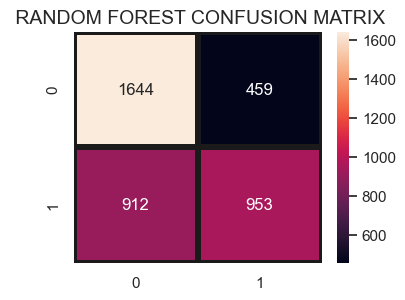

In [162]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, prediction_test),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title(" RANDOM FOREST CONFUSION MATRIX",fontsize=14)
plt.show()

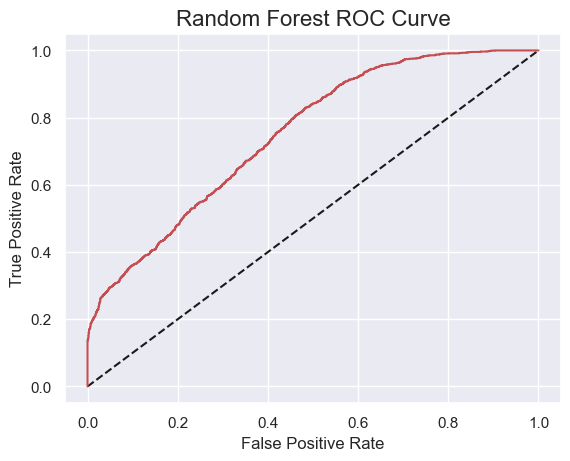

In [163]:
y_rfpred_prob = model_rf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_rfpred_prob)
plt.plot([0, 1], [0, 1], 'k--' )
plt.plot(fpr_rf, tpr_rf, label='Random Forest',color = "r")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve',fontsize=16)
plt.show();

# Decision TREE CLASSIFIER

In [1]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train,y_train)
predictdt_y = dt_model.predict(X_test)
accuracy_dt = dt_model.score(X_train,y_train)
print("Decision Tree accuracy is :",accuracy_dt)

NameError: name 'DecisionTreeClassifier' is not defined

In [290]:
print(classification_report(y_test, predictdt_y))

              precision    recall  f1-score   support

           0       0.66      0.64      0.65      2103
           1       0.61      0.62      0.61      1865

    accuracy                           0.63      3968
   macro avg       0.63      0.63      0.63      3968
weighted avg       0.63      0.63      0.63      3968



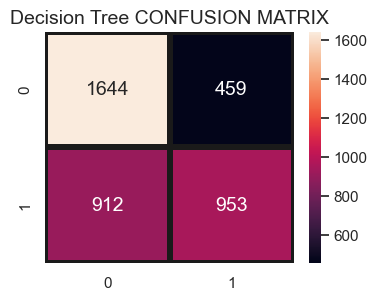

In [291]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, prediction_test),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title("Decision Tree CONFUSION MATRIX",fontsize=14)
plt.show()